In [1]:
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler

In [2]:
#start date, end date and symbol for Web.DataReader
start = datetime(2000,1,1)
end = datetime(2024,1,1)
symbol = "MSFT"

In [3]:
#pull data from stooq
df = web.DataReader(symbol, 'stooq', start, end)

In [4]:
print(df.head(10))

              Open     High       Low   Close      Volume
Date                                                     
2023-12-29  376.00  377.160  373.4800  376.04  18730838.0
2023-12-28  375.37  376.458  374.1600  375.28  14327013.0
2023-12-27  373.69  375.060  372.8116  374.07  14905412.0
2023-12-26  375.00  376.940  373.5000  374.66  12673050.0
2023-12-22  373.68  375.180  372.7100  374.58  17107484.0
2023-12-21  372.56  374.410  370.0400  373.54  17708006.0
2023-12-20  375.00  376.030  370.5300  370.62  26316650.0
2023-12-19  371.49  373.260  369.8400  373.26  20603658.0
2023-12-18  369.45  373.000  368.6800  372.65  21802878.0
2023-12-15  366.85  372.400  366.2800  370.73  78502324.0


In [5]:
df = df.iloc[::-1] # reverse data
print(df.head(10))

               Open     High      Low    Close        Volume
Date                                                        
2000-01-03  41.3784  41.8163  39.4783  41.0875  7.550068e+07
2000-01-04  40.0323  41.2832  39.5697  39.7047  7.676393e+07
2000-01-05  39.1675  41.0271  38.5540  40.1206  9.086396e+07
2000-01-06  39.5467  40.1444  38.2036  38.7774  7.798038e+07
2000-01-07  38.2890  39.5697  37.8264  39.2808  8.796185e+07
2000-01-10  39.9866  40.0720  39.2579  39.5697  6.377765e+07
2000-01-11  39.3015  40.2715  38.3108  38.5540  6.630246e+07
2000-01-12  38.2453  38.3773  36.8127  37.3002  9.437146e+07
2000-01-13  36.7879  38.2890  35.7753  38.0060  1.179338e+08
2000-01-14  37.7877  40.1603  37.2802  39.5697  1.041359e+08


In [6]:
print(df.shape)

(6037, 5)


In [7]:

#df['Date'] = pd.to_datetime(df['Date'])  # Ensure the Date column is datetime
#df.set_index('Date', inplace=True)  # Setting Date as index


#create variables for moving average
df['5_day_ma'] = df['Close'].rolling(window=5).mean()
df['7_day_ma'] = df['Close'].rolling(window=7).mean()
df['14_day_ma'] = df['Close'].rolling(window=14).mean()
df['30_day_ma'] = df['Close'].rolling(window=30).mean()

#create variable for daily returns
df['daily_returns'] = df['Close'].pct_change()

#create variables for volatility
df['2_day_volatility'] = df['daily_returns'].rolling(window=2).std()
df['5_day_volatility'] = df['daily_returns'].rolling(window=5).std()
df['7_day_volatility'] = df['daily_returns'].rolling(window=7).std()
df['14_day_volatility'] = df['daily_returns'].rolling(window=14).std()
df['30_day_volatility'] = df['daily_returns'].rolling(window=30).std()

#calculate support and resistance
for i in [5,10,15,20]:
    df[f'{i}_day_support'] = df['Close'].rolling(window=i).min()
    df[f'{i}_day_resistance'] = df['Close'].rolling(window=i).max()
    

print(df.shape)
print(df.head(10))

(6037, 23)
               Open     High      Low    Close        Volume  5_day_ma  \
Date                                                                     
2000-01-03  41.3784  41.8163  39.4783  41.0875  7.550068e+07       NaN   
2000-01-04  40.0323  41.2832  39.5697  39.7047  7.676393e+07       NaN   
2000-01-05  39.1675  41.0271  38.5540  40.1206  9.086396e+07       NaN   
2000-01-06  39.5467  40.1444  38.2036  38.7774  7.798038e+07       NaN   
2000-01-07  38.2890  39.5697  37.8264  39.2808  8.796185e+07  39.79420   
2000-01-10  39.9866  40.0720  39.2579  39.5697  6.377765e+07  39.49064   
2000-01-11  39.3015  40.2715  38.3108  38.5540  6.630246e+07  39.26050   
2000-01-12  38.2453  38.3773  36.8127  37.3002  9.437146e+07  38.69642   
2000-01-13  36.7879  38.2890  35.7753  38.0060  1.179338e+08  38.54214   
2000-01-14  37.7877  40.1603  37.2802  39.5697  1.041359e+08  38.59992   

             7_day_ma  14_day_ma  30_day_ma  daily_returns  ...  \
Date                             

In [8]:
df = df.dropna() #drop rows with NaN values in some columns
print(df.shape)
print(df.head(10))

(6006, 23)
               Open     High      Low    Close        Volume  5_day_ma  \
Date                                                                     
2000-02-15  35.1618  35.2512  34.5869  34.7488  1.007476e+08  35.82374   
2000-02-16  34.9900  35.3206  34.2375  34.4132  9.248523e+07  35.37380   
2000-02-17  34.7239  35.1409  34.2375  35.1151  1.139614e+08  34.92388   
2000-02-18  35.2512  35.2739  33.4403  33.5158  1.121452e+08  34.58160   
2000-02-22  33.5306  34.2375  32.7206  33.0730  9.403642e+07  34.17318   
2000-02-23  32.9617  33.7471  32.4504  33.2219  1.075838e+08  33.86780   
2000-02-24  33.2219  33.7987  32.4287  33.4016  9.891156e+07  33.66548   
2000-02-25  33.3787  33.3787  31.9005  32.1845  9.262537e+07  33.07936   
2000-02-28  31.8161  32.4744  31.0597  32.2797  1.079875e+08  32.83214   
2000-02-29  32.3394  32.3394  31.3287  31.5004  8.288928e+07  32.51762   

             7_day_ma  14_day_ma  30_day_ma  daily_returns  ...  \
Date                             

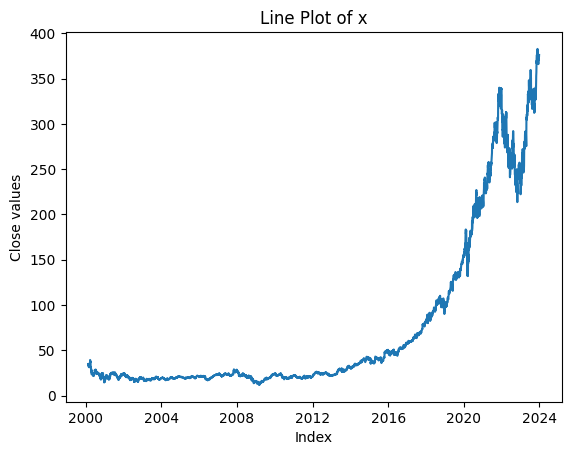

In [9]:
#look at the current graph for closing data
plt.plot(df.index, df['Close'])  # This plots 'x' against the DataFrame's index
plt.title('Line Plot of x')
plt.xlabel('Index')
plt.ylabel('Close values')
plt.show()


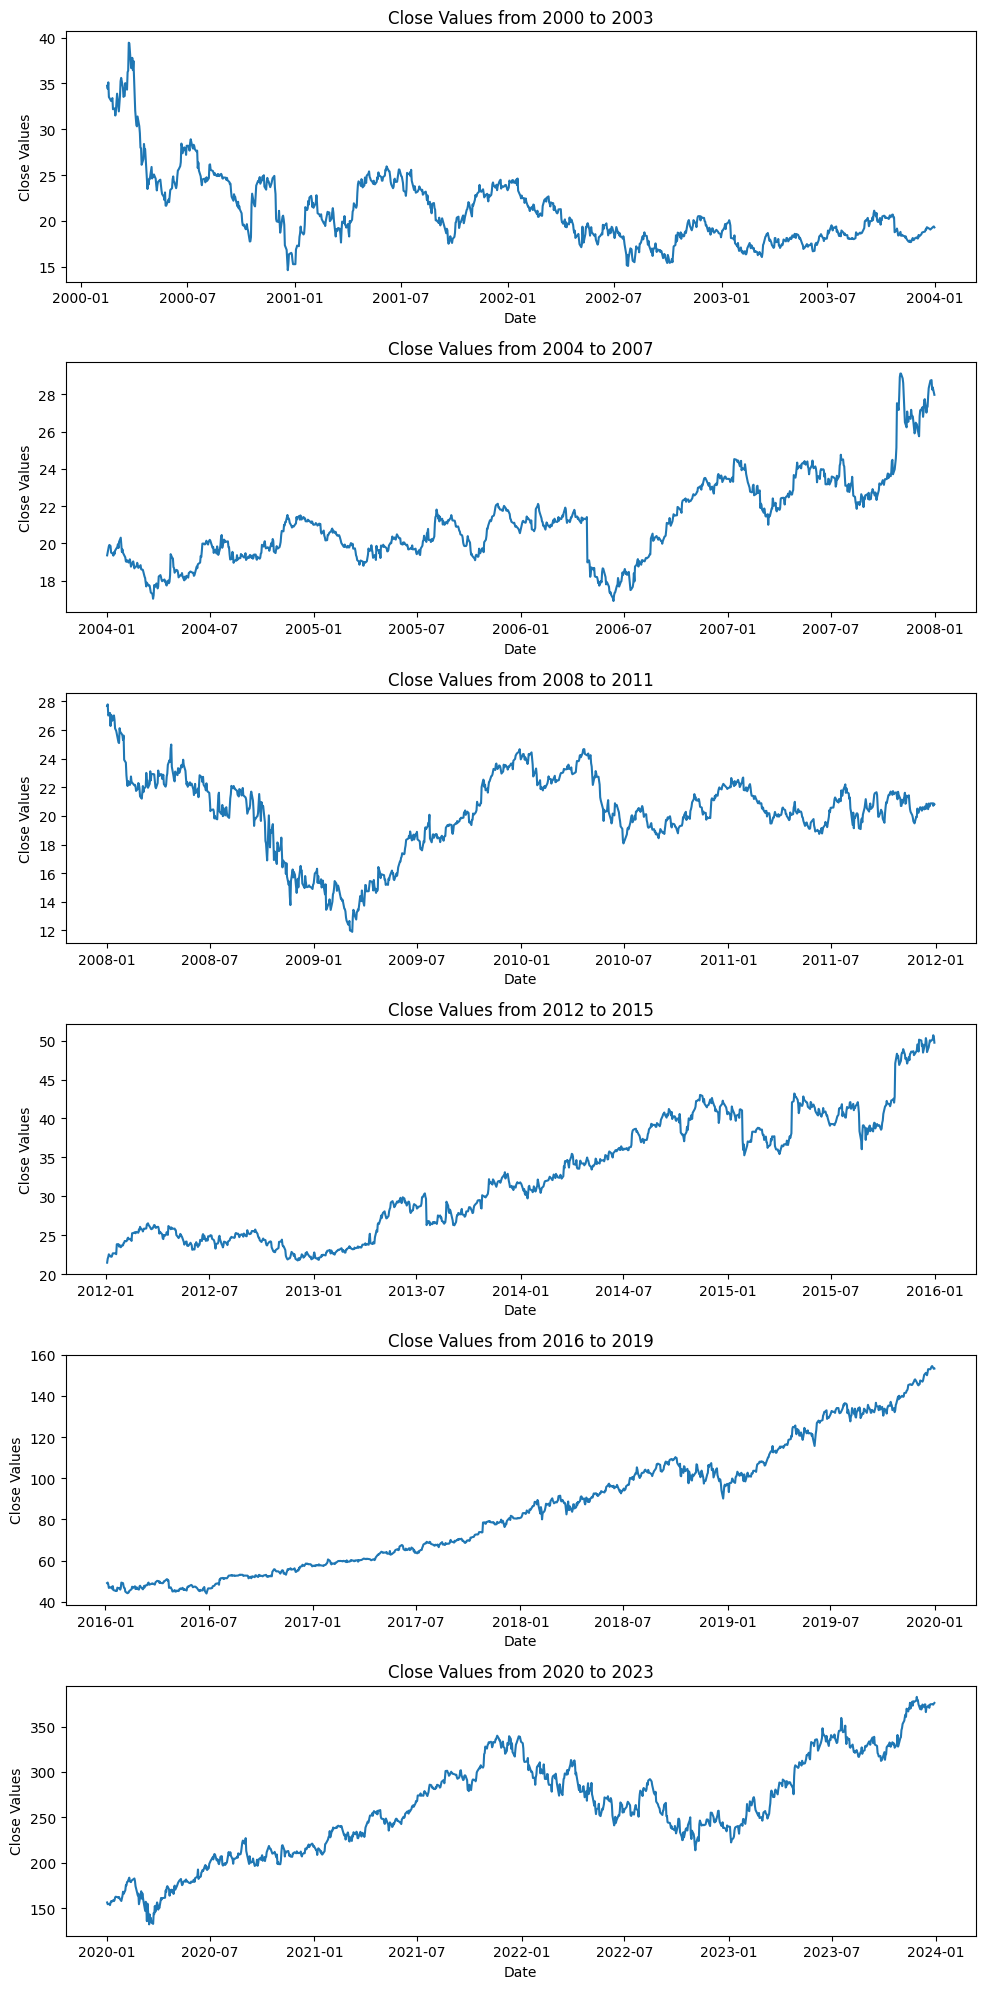

In [10]:
#plot over smaller interval to better analyze data
start_year = df.index.year.min()
end_year = df.index.year.max()

# Define the size of the overall figure
plt.figure(figsize=(10, 20))  

# Calculate the number of plots needed
num_plots = (end_year - start_year) // 4 + 1

for i in range(num_plots):
    # Calculate the current 4-year interval
    current_start_year = start_year + i*4
    current_end_year = min(current_start_year + 3, end_year)  # Ensure we don't go beyond the last year
    
    # Select the data for the current 4-year interval
    mask = (df.index.year >= current_start_year) & (df.index.year <= current_end_year)
    current_df = df.loc[mask]
    
    # Create a subplot for the current interval
    plt.subplot(num_plots, 1, i+1)  # Rows, Columns, Plot number
    plt.plot(current_df.index, current_df['Close'])
    plt.title(f'Close Values from {current_start_year} to {current_end_year}')
    plt.xlabel('Date')
    plt.ylabel('Close Values')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [11]:
data = df['Close'].values.reshape(-1, 1) #create a 2-d np array of shape (n,1)
#normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

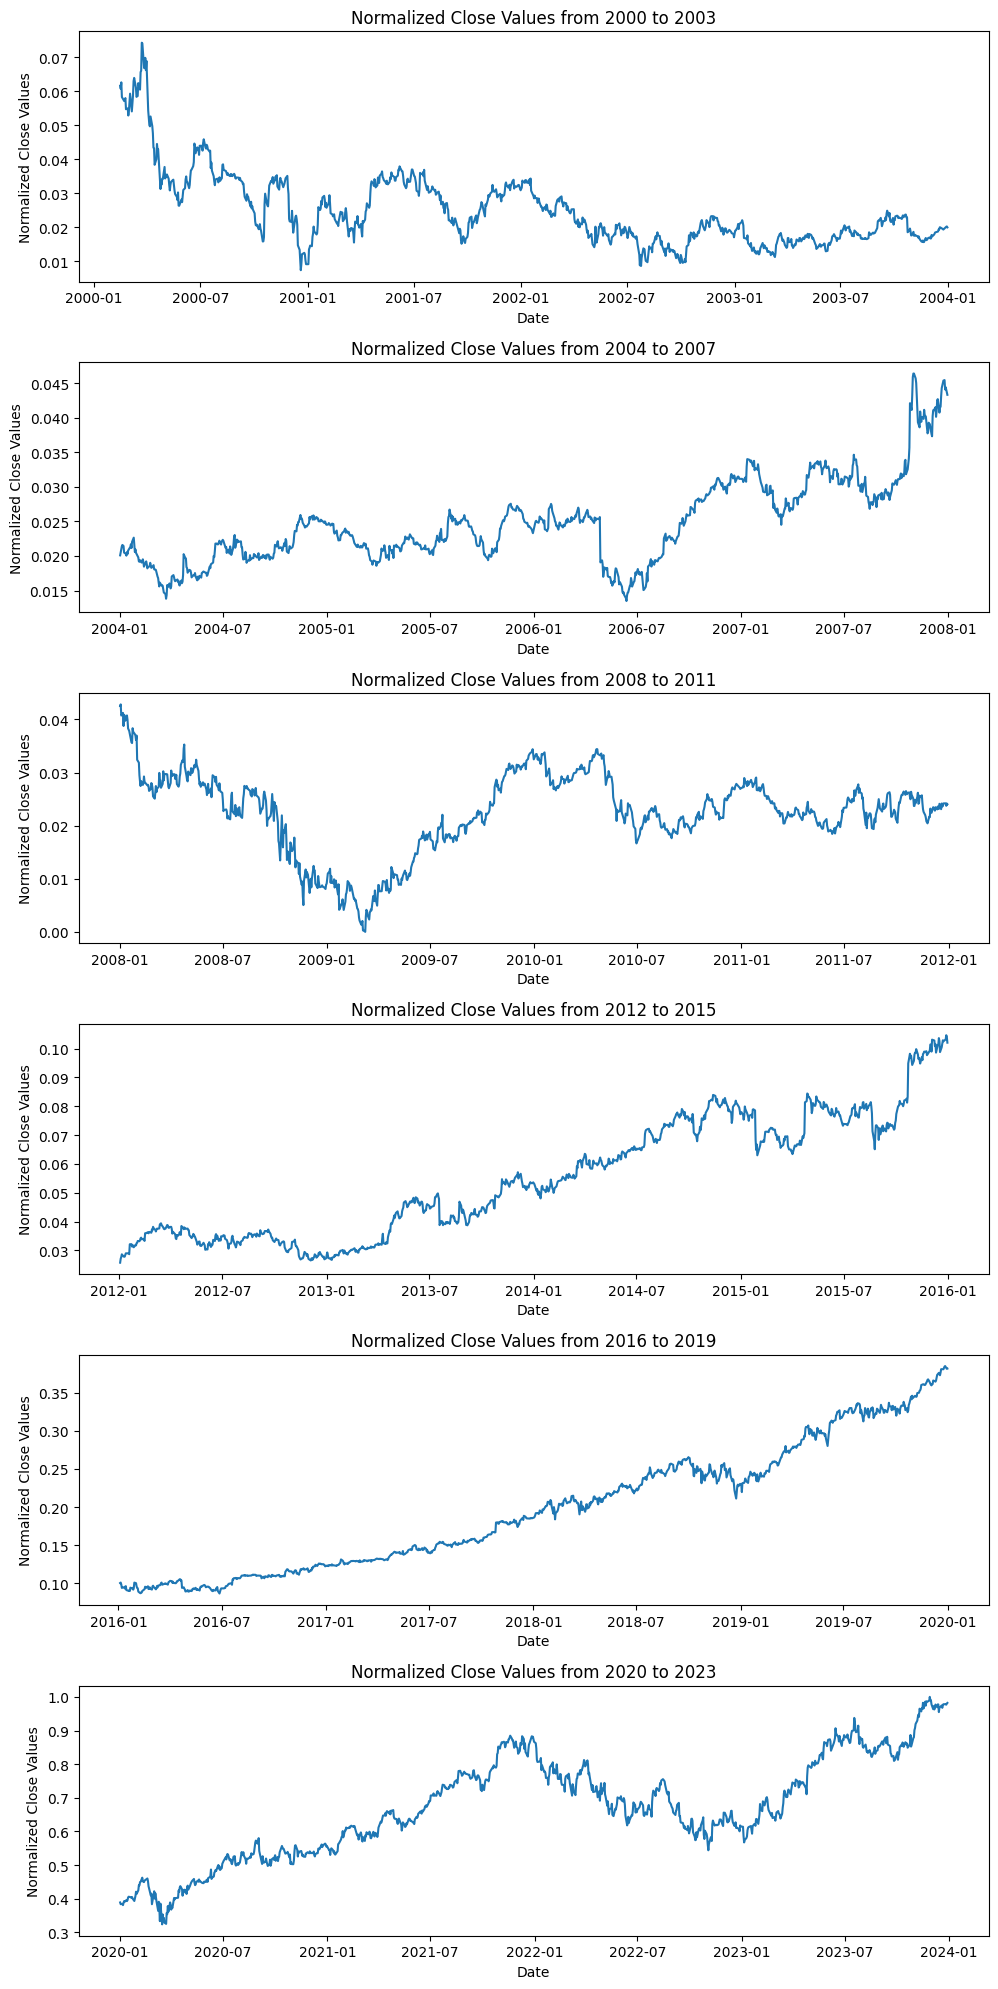

In [16]:
######################################visualize normalized data

# Convert data_normalized back to a DataFrame for easier handling with dates
data_normalized_df = pd.DataFrame(data_normalized, index=df.index, columns=['Normalized Close'])

# Define the size of the overall figure
plt.figure(figsize=(10, 20))

# Calculate the number of plots needed
start_year = df.index.year.min()
end_year = df.index.year.max()
num_plots = (end_year - start_year) // 4 + 1

for i in range(num_plots):
    # Calculate the current 4-year interval
    current_start_year = start_year + i*4
    current_end_year = min(current_start_year + 3, end_year)  # Ensure we don't go beyond the last year
    
    # Select the data for the current 4-year interval
    current_df = data_normalized_df[(data_normalized_df.index.year >= current_start_year) & (data_normalized_df.index.year <= current_end_year)]
    
    # Create a subplot for the current interval
    plt.subplot(num_plots, 1, i+1)  # Rows, Columns, Plot number
    plt.plot(current_df.index, current_df['Normalized Close'])
    plt.title(f'Normalized Close Values from {current_start_year} to {current_end_year}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Close Values')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()


In [17]:

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, y = create_dataset(data_normalized, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]
